In [1]:
# tutorials adapted for this notebook:
# https://github.com/ritvikmath/Time-Series-Analysis/blob/master/SARIMA%20Model.ipynb
# https://github.com/CoreyMSchafer/code_snippets/blob/master/Python/Pandas/10-Datetime-Timeseries/Pandas-Demo.ipynb
# https://github.com/gravesa333/Electricity_Load_Forecasting

In [2]:
import numpy as np
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
register_matplotlib_converters()

from datetime import timedelta
from datetime import datetime
from time import time

import warnings

<h4>Part 1: Download & prepare raw data for time-series analysis

In [3]:
# download all available datasets and import as dataframes
url = 'https://data.nationalgrideso.com/backend/dataset/8f2fe0af-871c-488d-8bad-960426f24601/resource/bb44a1b5-75b1-4db2-8491-257f23385006/download/demanddata.csv'
r = requests.get(url)  
df2022 = pd.read_csv(io.StringIO(r.text))

url = 'https://data.nationalgrideso.com/backend/dataset/8f2fe0af-871c-488d-8bad-960426f24601/resource/18c69c42-f20d-46f0-84e9-e279045befc6/download/demanddata_2021.csv'
r = requests.get(url)  
df2021 = pd.read_csv(io.StringIO(r.text))

url = 'https://data.nationalgrideso.com/backend/dataset/8f2fe0af-871c-488d-8bad-960426f24601/resource/33ba6857-2a55-479f-9308-e5c4c53d4381/download/demanddata_2020.csv'
r = requests.get(url)  
df2020 = pd.read_csv(io.StringIO(r.text))

url = 'https://data.nationalgrideso.com/backend/dataset/8f2fe0af-871c-488d-8bad-960426f24601/resource/dd9de980-d724-415a-b344-d8ae11321432/download/demanddata_2019.csv'
r = requests.get(url)  
df2019 = pd.read_csv(io.StringIO(r.text))

url = 'https://data.nationalgrideso.com/backend/dataset/8f2fe0af-871c-488d-8bad-960426f24601/resource/fcb12133-0db0-4f27-a4a5-1669fd9f6d33/download/demanddata_2018.csv'
r = requests.get(url)  
df2018 = pd.read_csv(io.StringIO(r.text))

url = 'https://data.nationalgrideso.com/backend/dataset/8f2fe0af-871c-488d-8bad-960426f24601/resource/2f0f75b8-39c5-46ff-a914-ae38088ed022/download/demanddata_2017.csv'
r = requests.get(url)  
df2017 = pd.read_csv(io.StringIO(r.text))

url = 'https://data.nationalgrideso.com/backend/dataset/8f2fe0af-871c-488d-8bad-960426f24601/resource/3bb75a28-ab44-4a0b-9b1c-9be9715d3c44/download/demanddata_2016.csv'
r = requests.get(url)  
df2016 = pd.read_csv(io.StringIO(r.text))

In [4]:
# Combine datasets from 2022-2016
frames = [df2022, df2021, df2020, df2019, df2018, df2017, df2016]
result = pd.concat(frames)

In [5]:
result

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,PUMP_STORAGE_PUMPING,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW
0,01-JAN-2022,1,21940,23275,20513,2412,6527,0,13080,0,450,-181,-4,586,320,384,-100,210.0,0.0
1,01-JAN-2022,2,22427,23489,21021,2554,6527,0,13080,0,173,-181,-4,583,320,403,-104,176.0,0.0
2,01-JAN-2022,3,21896,23672,20619,2696,6527,0,13080,0,799,-164,-4,567,320,440,-4,-205.0,0.0
3,01-JAN-2022,4,20693,23272,19615,2838,6527,0,13080,0,1516,-170,-4,444,320,387,-6,-283.0,0.0
4,01-JAN-2022,5,19481,23958,18545,2977,6527,0,13080,0,1490,-753,-4,-383,320,476,-561,-686.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17563,31-DEC-2016,44,29837,31233,27097,1735,4871,0,11503,0,5,-791,0,1000,159,59,0,NaN,NaN
17564,31-DEC-2016,45,28701,30304,26042,1742,4871,0,11503,0,5,-998,0,1000,221,116,0,NaN,NaN
17565,31-DEC-2016,46,28188,29800,25464,1750,4871,0,11503,0,11,-1001,0,999,206,213,0,NaN,NaN
17566,31-DEC-2016,47,27429,28126,24730,1694,4871,0,11503,0,20,-77,0,910,225,248,0,NaN,NaN


In [6]:
# keep ND column only--added copy() to suppress "copy of a slice" error
# TDS not used because it includes generation to "meet station load, pump storage pumping and interconnector exports"
# source: https://data.nationalgrideso.com/demand/historic-demand-data/r/historic_demand_data_2022
df = result[['SETTLEMENT_DATE','SETTLEMENT_PERIOD','ND']].copy()

# rename columns
df.columns = ['Date','Period','Demand_MW']

# recast date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y')

# make dataset a time series by using date as index
df.set_index('Date', inplace = True)

In [7]:
# resample to daily values, using the sum of demand (in MW) from all 48 settlement periods per day
df.resample('D').agg({'Demand_MW':'sum'})

,Demand_MW
Date,
2016-01-01,1409280
2016-01-02,1443410
2016-01-03,1480766
2016-01-04,1732697
2016-01-05,1780970
...,...
2022-08-09,1165145
2022-08-10,1172631
2022-08-11,1181033


In [8]:
# resample data to quarterly totals of demand 
df_qtr = df.resample('Q').agg({'Demand_MW':'sum'})

# convert quarterly totals to gigawatts (GW)
df_qtr['Demand_GW'] = df_qtr['Demand_MW']/1000

# delete column containing MW data
df_qtr.drop('Demand_MW', axis = 1, inplace=True)

<AxesSubplot:xlabel='Date'>

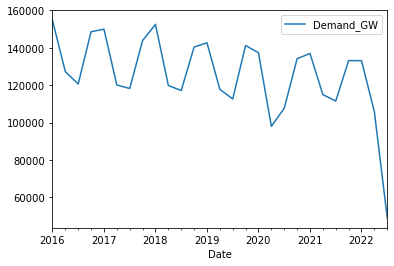

In [9]:
df_qtr.plot()

The above initial plot shows that the monthly totals for August is incomplete, so it needs to be excluded to prevent modelling errors later on.

In [10]:
# limit time series to exclude 2022 data (and use for comparing against forecasted 2022 data)
# code based on https://www.alpharithms.com/pandas-time-series-select-sub-set-range-463215/
train_df_qtr = df_qtr.loc['2016-03-31':'2021-12-31']

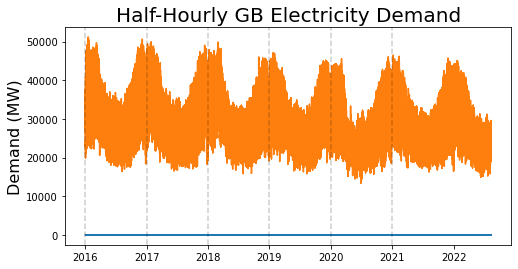

In [11]:
# plot original, unsampled dataset to include in report
plt.figure(figsize=(8,4))
plt.plot(df)
plt.title('Half-Hourly GB Electricity Demand', fontsize=20)
plt.ylabel('Demand (MW)', fontsize=16)
for year in range(2016, 2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

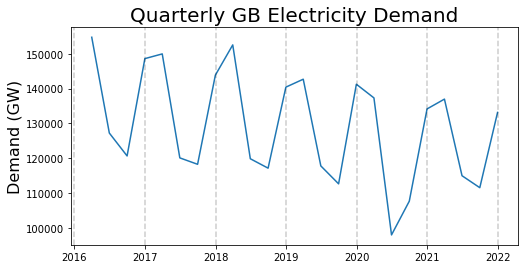

In [12]:
plt.figure(figsize=(8,4))
plt.plot(train_df_qtr)
plt.title('Quarterly GB Electricity Demand', fontsize=20)
plt.ylabel('Demand (GW)', fontsize=16)
for year in range(2016, 2023):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [13]:
# Resampling to monthly totals and coverting to GW
df_mth = df.resample('M').agg({'Demand_MW':'sum'})
df_mth['Demand_GW'] = df_mth['Demand_MW']/1000
df_mth.drop('Demand_MW', axis = 1, inplace=True)

In [14]:
# limit time series to exclude 2022 data (and use for comparing against forecasted 2022 data)
# https://www.alpharithms.com/pandas-time-series-select-sub-set-range-463215/
train_df_mth = df_mth.loc['2016-03-31':'2021-12-31']

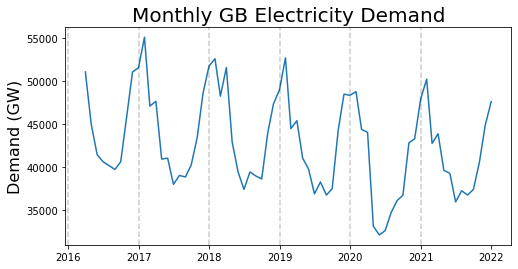

In [15]:
plt.figure(figsize=(8,4))
plt.plot(train_df_mth)
plt.title('Monthly GB Electricity Demand', fontsize=20)
plt.ylabel('Demand (GW)', fontsize=16)
for year in range(2016, 2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Part 1 conclusion: Continue with model selection and configuration using the monthly time-series.  The monthly plot above shows a downward, seasonal trend, so the next step will include differencing to make the data stationary before the the data is fitted to the model.

<h4>Part 2: Identify Parameters for SARIMA Model</h4>
<p>Step 1: Apply differencing to non-stationary data

In [16]:
# # use ACF and PACF plots to calculate statistically significant lags 
# # (outside)
# fig,ax = plt.subplots(2,1,figsize=(10,8))
# fig = sm.graphics.tsa.plot_acf(np.log(train_df_mth), lags=30, ax=ax[0])
# fig = sm.graphics.tsa.plot_pacf(np.log(train_df_mth), lags=30, ax=ax[1])
# ax[0].set_xlim(0, 32)
# ax[1].set_xlim(0, 32)
# plt.show()

In [17]:
# apply the first difference to the non-seasonal component
train_diff = train_df_mth.diff()

# apply the seasonal difference
train_seas = train_df_mth.diff(12)

train_both = train_seas.diff()

In [18]:
train_seas.head(20)

,Demand_GW
Date,
2016-03-31,NaN
2016-04-30,NaN
2016-05-31,NaN
2016-06-30,NaN
2016-07-31,NaN
2016-08-31,NaN
2016-09-30,NaN
2016-10-31,NaN
2016-11-30,NaN


Step 2: verify stationarity of the non-seasonal component with Augmented Dickey-Fuller test (ADF). If the p-value from the ADF test less than 0.05, the data is stationary.

In [19]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(train_diff[1:])
pvalue

0.008348845296931697

Stationarity is confirmed with a p-value of 0.0083488, which is less than 0.05.  The first differencing of the non-seasonal component means that the parameter <i>d</i> = 1 when building the SARIMA model.

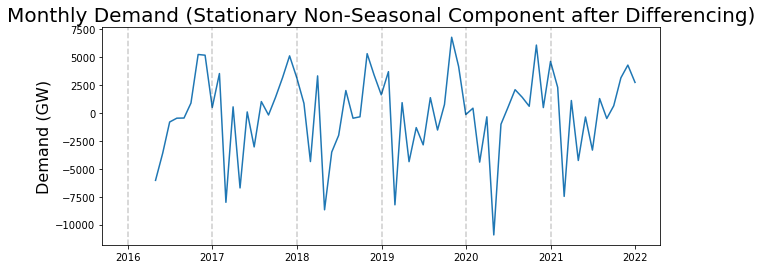

In [20]:
# plot the first difference of the non-seasonal component to show the trending is removed
plt.figure(figsize=(10,4))
plt.plot(train_diff)
plt.title('Monthly Demand (Stationary Non-Seasonal Component after Differencing)', fontsize=20)
plt.ylabel('Demand (GW)', fontsize=16)
for year in range(2016, 2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Step 3: use ACF (autocorrelation function) and PACF (partial autocorrelation) plots to determine the values for <i>p</i> and <i>q</i> of the non-seasonal component.

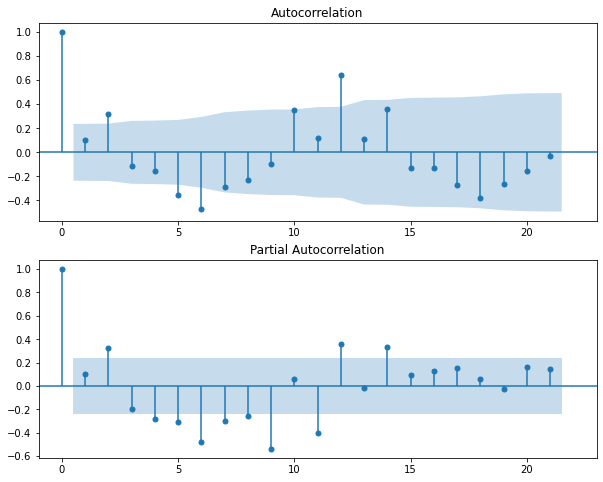

In [21]:
fig,ax = plt.subplots(2,1,figsize=(10,8))
fig = sm.graphics.tsa.plot_acf(train_diff[1:], lags=21, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train_diff[1:], lags=21, ax=ax[1])
ax[0].set_xlim(-1, 23)
ax[1].set_xlim(-1, 23)
plt.show()

The value for <i>p</i> comes from the first positive statistically significant spike (outside the blue areas) after 0 lags. In both plots, this occurs at 2 lags, so <i>p</i> = 2.  The next positive spike outside the blue area is 12, which confirms the 12-month seasonality of the data. 

Step 4: Run the ADF test to determine stationarity of the seasonal differenced component

In [22]:
# the first 11 value of the seasonal differenced data are null, 
# so ADF only works from the 12th data point
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(train_seas[12:])
pvalue

0.0003339326684460726

Stationarity is confirmed with a p-value of 0.000334, which is less than 0.05.  Therefore, the first differencing of the seasonal component makes <i>D</i> = 1.

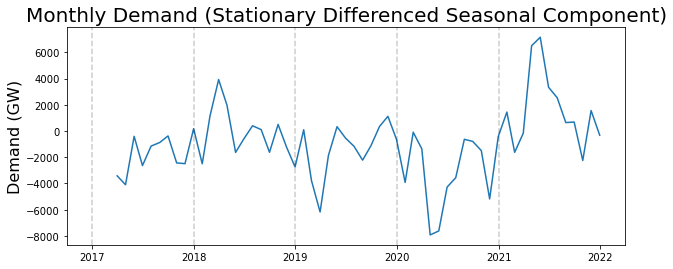

In [23]:
# plot the first difference of the non-seasonal component to show the trending is removed

plt.figure(figsize=(10,4))
plt.plot(train_seas)
plt.title('Monthly Demand (Stationary Differenced Seasonal Component)', fontsize=20)
plt.ylabel('Demand (GW)', fontsize=16)
for year in range(2017, 2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Step 5: make ACF (autocorrelation function) and PACF (partial autocorrelation) plots to determine the values for <i>P</i> and <i>Q</i> of the seasonal component.

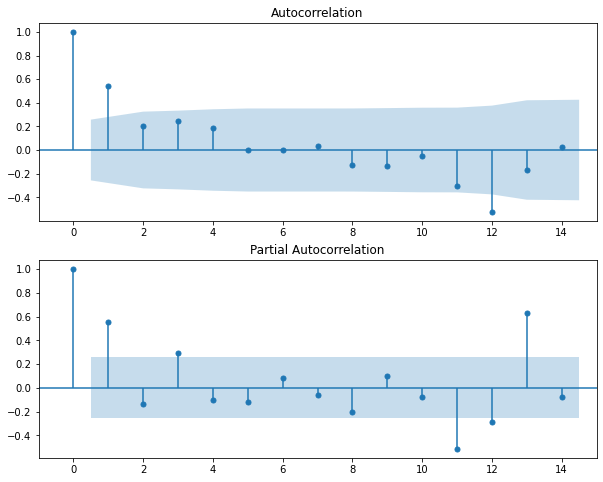

In [24]:
fig,ax = plt.subplots(2,1,figsize=(10,8))
fig = sm.graphics.tsa.plot_acf(train_seas[12:], lags=14, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train_seas[12:], lags=14, ax=ax[1])
ax[0].set_xlim(-1, 15)
ax[1].set_xlim(-1, 15)
plt.show()

The value for <i>P</i> comes from the first positive statistically significant spike (outside the blue areas) after 0 lags. In both plots, this occurs at 1 lag, so <i>P</i> = 1.  The next positive spike outside the blue area is 12, which confirms the 12-month seasonality of the data. 

<H1><i>Rewrite section for determining q and Q.  Current version doesn't make sense

<h3>Seasonal difference (called "First + seasonal difference" in tutorial)

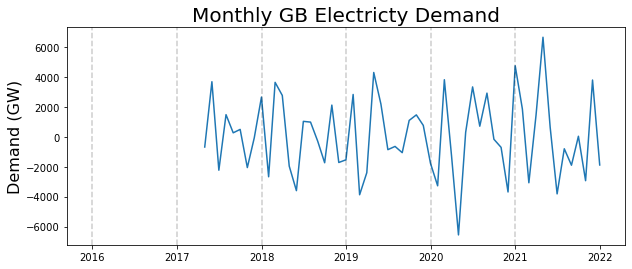

In [25]:
# plt.figure(figsize=[21,7])
# plt.plot(train_both)

plt.figure(figsize=(10,4))
plt.plot(train_both)
plt.title('Monthly GB Electricty Demand', fontsize=20)
plt.ylabel('Demand (GW)', fontsize=16)
for year in range(2016, 2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

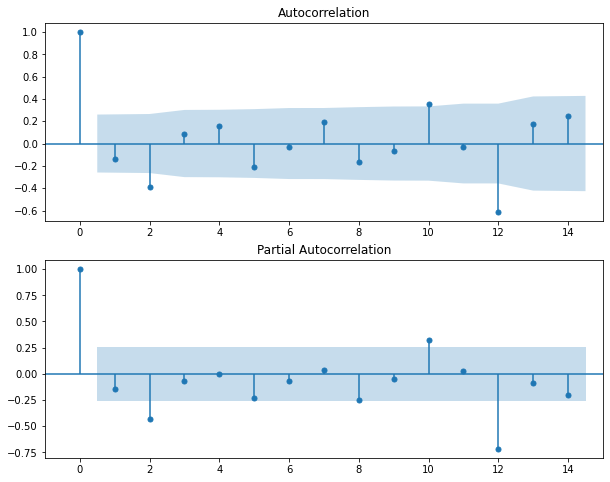

In [26]:
fig,ax = plt.subplots(2,1,figsize=(10,8))
fig = sm.graphics.tsa.plot_acf(train_both[13:], lags=14, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train_both[13:], lags=14, ax=ax[1])
ax[0].set_xlim(-1, 15)
ax[1].set_xlim(-1, 15)
plt.show()

Looking at ACF/PACF plots for both first differenced & seasonal plots:
<br>-there are significant negative spikes in the ACF plot at lags 2 and 12
<br>-there are also significant negative spikes in the PACF plot at lags 2 and 12 
<br>-p = 2 (significant positive spikes at 2 in ACF & PACF plots)
<br>-P = 0 (no significant positive spikes in ACF & PACF plots)
<br>-d = 1 (first difference)
<br>-D = 0 (no seasonal difference)
<br>-q and Q both = 1 (significant negative spikes)
<br>-For first SARIMA model, this indicates a potential parameter starting point of SARIMA(2,1,1)x(0,0,1,12)
<br>These are the same parameters from ML Mastery's grid search script

<p>(from https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c)
<br>The blue area in the ACF & PACF plots depicts the 95% confidence interval and is an indicator of the <b>significance threshold</b>.  This means anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

<p>To determine the order of the model, you check:
“How many lollipops are above or below the confidence interval before the next lollipop enters the blue area?”

<h4>Part 3: Fit the SARIMA model</h4>
<p>Step 1: Get training and testing sets

In [27]:
# set end of training data to the start of 2022 as January-July values will be predicted with the model
train_end = datetime(2022,1,1)

# set end of testing data to the start of August 2022, as August 2022 monthly data is incomplets
test_end = datetime(2022,8,1)

train_data = df_mth[:train_end]
test_data = df_mth['Demand_GW'][train_end + timedelta(days=1):test_end]


In [28]:
my_order = (2,1,1) # values for SARIMA (p,d,q)
my_seasonal_order = (0, 1, 1, 12) # values for SARIMA (P,D,Q,S)

# define model
model = SARIMAX(train_data, order = my_order, seasonal_order = my_seasonal_order)

# fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

/Users/doris/opt/anaconda3/envs/epf/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13431D+00    |proj g|=  2.17221D+00

At iterate    5    f=  7.58558D+00    |proj g|=  7.33265D-03

At iterate   10    f=  7.58150D+00    |proj g|=  1.69304D-01

At iterate   15    f=  7.56694D+00    |proj g|=  1.98405D-02

At iterate   20    f=  7.56642D+00    |proj g|=  5.75075D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     26      1     0     0   2.957D-05   7.566D+00
  F =   7.5664241748427328     

CONVERG

In [29]:
# summary of the model to evaluate p-values (looking for values less than 0.05 for ar.L1, ar.L2, ma.L1)
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Demand_GW   No. Observations:                   72
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -544.783
Date:                            Sun, 04 Sep 2022   AIC                           1099.565
Time:                                    20:54:09   BIC                           1109.953
Sample:                                01-31-2016   HQIC                          1103.620
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6722      0.255     -2.640      0.008      -1.171      -0.173
ar.L2         -0.0383      0.065   

<h4>Part 4: Make predictions with the model and compare against actual values</h4>
Step 1: Calculate predicted values

In [30]:
# calculate predicted values
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)

# verify the quality of the SARIMA model based on values of the residual forecast errors
# residuals = test_data['Demand_GW'] - predictions
residuals = test_data - predictions

Step 2: Calculate residual errors to verify quality of SARIMA model

Text(0, 0.5, 'Error')

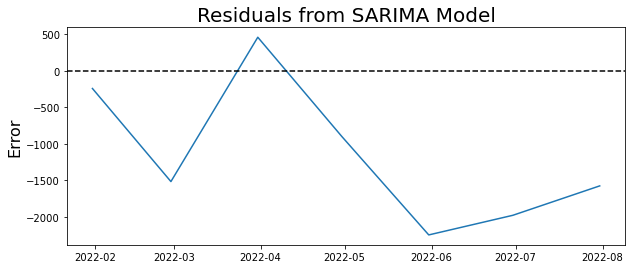

In [31]:
# plot the residual forecast errors.  Ideal result should show values centred around 0.
# https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Step 3: Plot predicted values vs. actual values 

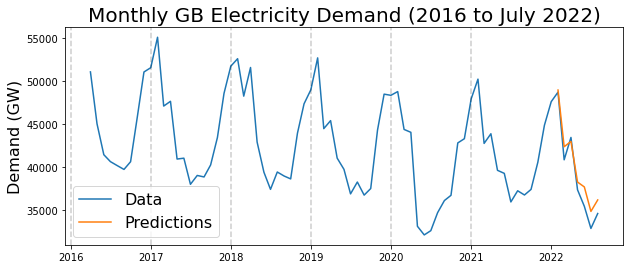

In [32]:
# plot predicted values vs. actual values for January-July 2022
plt.figure(figsize=(10,4))

plt.plot(df_mth.loc['2016-03-31':'2022-08-01'])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Monthly GB Electricity Demand (2016 to July 2022)', fontsize=20)
plt.ylabel('Demand (GW)', fontsize=16)
# for year in range(2016,2022):
#     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
for year in range(2016,2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Step 4: Calculate error of forecast values against actual values.

In [33]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0351


In [34]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1456.7854257397476
